# Preprocessing

In [1]:
# from google.colab import files

In [2]:
# uploaded = files.upload()

In [3]:
import numpy as np
import pandas as pd
import json
import torch
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import brown
nltk.download('punkt')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
import gensim
import logging
from tqdm import tqdm

np.random.seed(0)
torch.manual_seed(0)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bharatsuri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model = gensim.models.keyedvectors.Word2VecKeyedVectors.load_word2vec_format('glove.42B.300d.w2vformat.txt')

2021-04-08 19:13:27,305 : INFO : loading projection weights from glove.42B.300d.w2vformat.txt
2021-04-08 19:17:02,848 : INFO : loaded (1917494, 300) matrix from glove.42B.300d.w2vformat.txt


In [5]:
def getSentenceVector(sentence):
    words = word_tokenize(sentence)
    count_present = 0
    vec = np.zeros(300)
    for word in words:
        if word in model.wv:
            vec = np.add(vec, np.array(model.wv[word]))
            count_present += 1
    if count_present > 0:
        vec = vec / count_present
    return vec

In [77]:
class YelpDataset(Dataset):
    """Yelp dataset."""
    
    def __init__(self, file_name, append_zeros = True):
        """
        Args:
            file_name: The json file to make the dataset from
        """
        self.df = pd.read_json(file_name, lines=True)

        tensors = []
        sent_tkn = []
        binary_cat = []
        zero_sentence = np.zeros(300)

        #Create target class and document vector for each review
        for index, row in self.df.iterrows():
            single_class = np.zeros(2)
            if row['category'] == 1:
                single_class[1] = 1
            else:
                single_class[0] = 1
            binary_cat.append(torch.tensor(single_class))

            sentences = sent_tokenize(row['text'])
            sent_tkn.append(sentences)
            sent_vecs = []
            for i in range(20):
                if i < len(sentences):
                    sent_vecs.append(getSentenceVector(sentences[i]))
                elif append_zeros:
                    sent_vecs.append(zero_sentence.copy())
            tensors.append(torch.FloatTensor(sent_vecs))

        self.df['category'] = binary_cat
        self.df['vector'] = tensors
        self.df['sentences'] = sent_tkn

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        category = self.df.iloc[idx, 0]
        text = self.df.iloc[idx, 1]
        vector = self.df.iloc[idx, 2]
        sents = self.df.iloc[idx, 3]
        sample = {'vector': vector, 'category': category, 'text': text, 'sentences': sents}

        return sample

In [78]:
### DO NOT APPEND ZEROS ###
#append_zeros = False
dataset_train = YelpDataset('dataset1/dataset_train.json', False)
dataset_dev = YelpDataset('dataset1/dataset_dev.json', False)
dataset_test = YelpDataset('dataset1/dataset_test.json', False)

<ipython-input-5-9dc5e6bd6841>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in model.wv:
<ipython-input-5-9dc5e6bd6841>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = np.add(vec, np.array(model.wv[word]))
<ipython-input-5-9dc5e6bd6841>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in model.wv:
<ipython-input-5-9dc5e6bd6841>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = np.add(vec, np.array(model.wv[word]))
<ipython-input-5-9dc5e6bd6841>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in model.wv:
<ipython-input-5-9dc5e6bd6841>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vec = np.add(vec, np.array(model.

In [8]:
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, 
                              num_workers=0)
dataloader_dev = DataLoader(dataset_dev, batch_size=1, shuffle=True, 
                              num_workers=0)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=True, 
                              num_workers=0)

In [9]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class GRUAttention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUAttention, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.attn = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Tanh()
        )
        
        self.fcn = nn.Sequential(
            nn.Linear(2*hidden_size, 64),
            nn.Tanh(),
            nn.Dropout(0.8),
            nn.Linear(64, 2),
            nn.Tanh()
        )

    def forward(self, inputs):
        output, hidden = self.gru(inputs)
        attn_weights = self.attn(output)
        attn_scores = F.softmax(attn_weights, 1)
        out = torch.bmm(output.transpose(1, 2), attn_scores).squeeze(2)
        logits = self.fcn(out)
        return logits, attn_scores.squeeze(2)

In [13]:
from tqdm import tqdm
encoder = GRUAttention(300, 64)
criterion = nn.CrossEntropyLoss()

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)

epochs = 10
total = 0
for n in range(epochs):
    epoch_loss = 0
    for sample_batched in tqdm(dataloader_train):
        encoder.train()
        encoder.zero_grad()
        loss = 0
        seq = sample_batched['vector']
        output, scores = encoder(seq)
        output = output.view(1, -1)
        arg_max = torch.argmax(sample_batched['category'][0])
        target = torch.tensor([arg_max])
        loss += criterion(output, target)
        epoch_loss+=loss.detach().item()
        loss.backward()

        encoder_optimizer.step()

    print("Average loss at epoch {}: {}".format(n, epoch_loss/len(dataloader_train)))
    validate()



  2%|▏         | 218/10000 [00:00<00:08, 1091.07it/s]

Average loss at epoch 0: 0.3781980966493487


  0%|          | 34/50000 [00:00<05:09, 161.62it/s]

Accuracy: 0.8865


  1%|          | 117/10000 [00:00<00:08, 1157.27it/s]

Average loss at epoch 1: 0.3293533987894654


  0%|          | 36/50000 [00:00<04:42, 176.58it/s]

Accuracy: 0.8897


  1%|          | 118/10000 [00:00<00:08, 1171.58it/s]

Average loss at epoch 2: 0.3189781457749009


  0%|          | 14/50000 [00:00<06:03, 137.37it/s]

Accuracy: 0.8909


  2%|▏         | 221/10000 [00:00<00:08, 1108.94it/s]

Average loss at epoch 3: 0.31016397529035805


  0%|          | 35/50000 [00:00<04:57, 168.14it/s]

Accuracy: 0.892


  1%|          | 118/10000 [00:00<00:08, 1173.51it/s]

Average loss at epoch 4: 0.3038716750743985


  0%|          | 16/50000 [00:00<05:33, 149.90it/s]

Accuracy: 0.8929


  2%|▏         | 236/10000 [00:00<00:08, 1183.64it/s]

Average loss at epoch 5: 0.29762729391932485


  0%|          | 15/50000 [00:00<05:44, 145.30it/s]

Accuracy: 0.8936


  2%|▏         | 225/10000 [00:00<00:08, 1136.03it/s]

Average loss at epoch 6: 0.29058568278849123


  0%|          | 15/50000 [00:00<05:42, 146.02it/s]

Accuracy: 0.8965


  2%|▏         | 229/10000 [00:00<00:08, 1147.61it/s]

Average loss at epoch 7: 0.2849643821018934


  0%|          | 12/50000 [00:00<07:08, 116.64it/s]

Accuracy: 0.8933


  2%|▏         | 228/10000 [00:00<00:08, 1141.06it/s]

Average loss at epoch 8: 0.2795842059907317


  0%|          | 18/50000 [00:00<04:40, 178.34it/s]

Accuracy: 0.8948


  2%|▏         | 229/10000 [00:00<00:08, 1146.44it/s]

Average loss at epoch 9: 0.27370845634549856


  0%|          | 18/50000 [00:00<04:53, 170.07it/s]

Accuracy: 0.9003


  1%|          | 115/10000 [00:00<00:08, 1141.53it/s]

Average loss at epoch 10: 0.2680808797055483


  0%|          | 17/50000 [00:00<05:04, 163.95it/s]

Accuracy: 0.8986


  2%|▏         | 221/10000 [00:00<00:08, 1108.05it/s]

Average loss at epoch 11: 0.2634323854753375


  0%|          | 16/50000 [00:00<05:15, 158.46it/s]

Accuracy: 0.8928


  2%|▏         | 230/10000 [00:00<00:08, 1147.90it/s]

Average loss at epoch 12: 0.25711179570376874


  0%|          | 30/50000 [00:00<05:43, 145.59it/s]

Accuracy: 0.8986


  2%|▏         | 211/10000 [00:00<00:09, 1054.45it/s]

Average loss at epoch 13: 0.2515276097279787


  0%|          | 16/50000 [00:00<05:26, 153.13it/s]

Accuracy: 0.8973


  2%|▏         | 227/10000 [00:00<00:08, 1142.00it/s]

Average loss at epoch 14: 0.24682795467466115


  0%|          | 18/50000 [00:00<04:48, 173.40it/s]

Accuracy: 0.8969


  1%|          | 124/10000 [00:00<00:08, 1230.27it/s]

Average loss at epoch 15: 0.24265611983388663


  0%|          | 32/50000 [00:00<05:24, 154.15it/s]

Accuracy: 0.8937


  2%|▏         | 230/10000 [00:00<00:08, 1153.94it/s]

Average loss at epoch 16: 0.23771711099982262


  0%|          | 17/50000 [00:00<04:57, 167.94it/s]

Accuracy: 0.889


  1%|          | 112/10000 [00:00<00:08, 1113.84it/s]

Average loss at epoch 17: 0.2344077875211835


  0%|          | 17/50000 [00:00<05:01, 165.71it/s]

Accuracy: 0.8951


  2%|▏         | 216/10000 [00:00<00:09, 1084.19it/s]

Average loss at epoch 18: 0.23032030680149793


  0%|          | 16/50000 [00:00<05:33, 149.73it/s]

Accuracy: 0.8861


  2%|▏         | 235/10000 [00:00<00:08, 1172.54it/s]

Average loss at epoch 19: 0.2269072103741765


  0%|          | 36/50000 [00:00<04:47, 174.04it/s]

Accuracy: 0.8911


  1%|          | 111/10000 [00:00<00:08, 1107.26it/s]

Average loss at epoch 20: 0.22267306887030602


  0%|          | 15/50000 [00:00<05:44, 145.06it/s]

Accuracy: 0.892


  2%|▏         | 222/10000 [00:00<00:08, 1109.92it/s]

Average loss at epoch 21: 0.219911370549798


  0%|          | 14/50000 [00:00<05:59, 139.17it/s]

Accuracy: 0.8883


  1%|          | 115/10000 [00:00<00:08, 1146.36it/s]

Average loss at epoch 22: 0.21738837560355664


  0%|          | 14/50000 [00:00<06:01, 138.45it/s]

Accuracy: 0.8951


  1%|          | 105/10000 [00:00<00:09, 1048.87it/s]

Average loss at epoch 23: 0.21495739534795286


  0%|          | 12/50000 [00:00<07:05, 117.50it/s]

Accuracy: 0.8914


  2%|▏         | 231/10000 [00:00<00:08, 1153.02it/s]

Average loss at epoch 24: 0.2128967802876234


100%|██████████| 10000/10000 [00:08<00:00, 1152.50it/s]

Accuracy: 0.8959


In [14]:
encoder.eval()
with torch.no_grad():
    total_correct = 0
    total = 0
    for sample_batched in tqdm(dataloader_train):

        loss = 0
        output, scores = encoder(sample_batched['vector'])
        classification = torch.argmax(output)
        arg_max = torch.argmax(sample_batched['category'][0])
        if classification == arg_max:
            total_correct+=1
    print("Accuracy: {}".format(total_correct/len(dataloader_train)))

100%|██████████| 50000/50000 [00:43<00:00, 1151.62it/s]

Accuracy: 0.96148


In [12]:
def validate():
    encoder.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for sample_batched in tqdm(dataloader_dev):

            loss = 0
            output, scores = encoder(sample_batched['vector'])
            classification = torch.argmax(output)
            arg_max = torch.argmax(sample_batched['category'][0])
            if classification == arg_max:
                total_correct+=1
    print("Accuracy: {}".format(total_correct/len(dataloader_dev)))

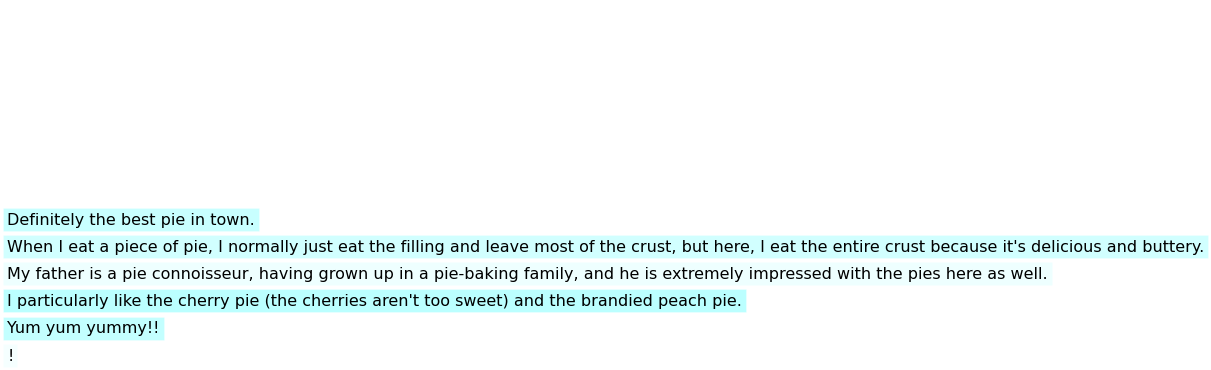

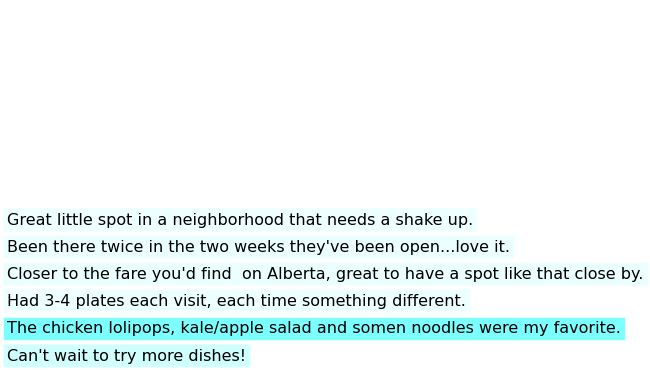

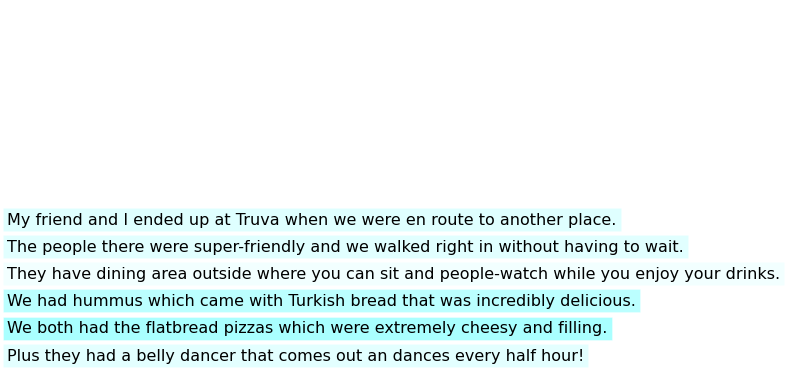

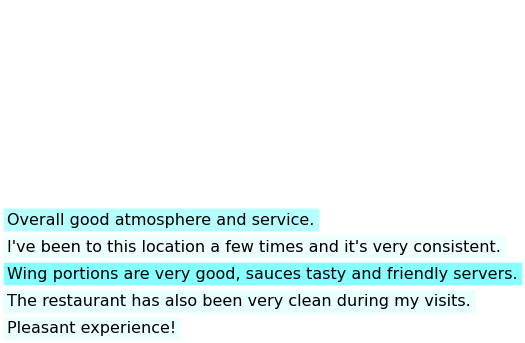

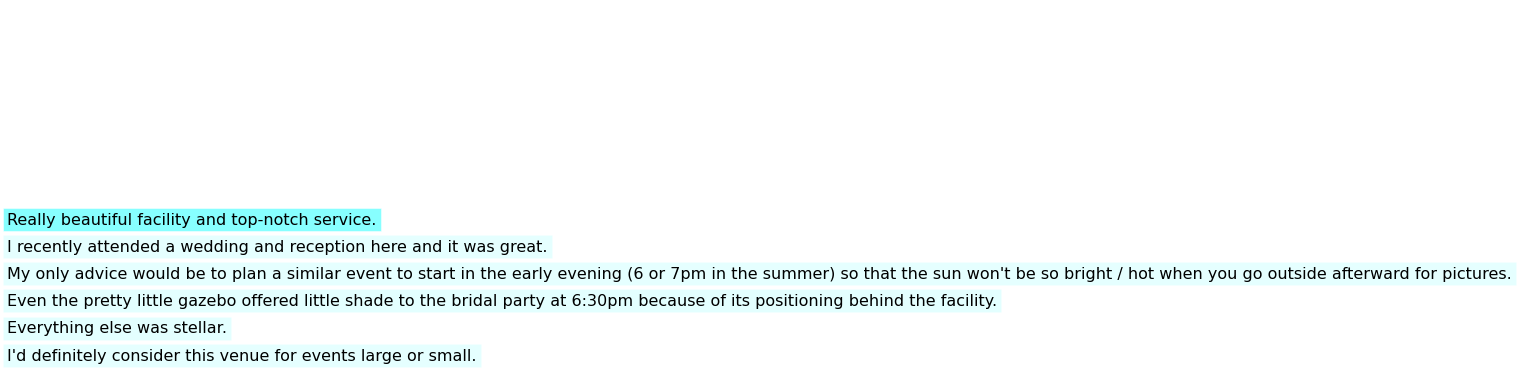

In [81]:
import matplotlib.pyplot as plt
c = 0
encoder.eval()
with torch.no_grad():
    for i in range(len(dataset_dev)):
        x = dataset_dev[i]
        n = len(x['sentences'])
        y, w = encoder(x['vector'].unsqueeze(0))
        p = torch.argmax(y)
        if p.item() == 1 and n < 8 and torch.argmax(x['category']).item() == 1:
            c += 1
            fig, ax = plt.subplots()
            for idx, (a, b) in enumerate(zip(x['sentences'], w[0])):
                t = ax.text(0, -idx/8, a, fontsize=16)
                t.set_bbox(dict(facecolor='cyan', alpha=b.item(), edgecolor='white'))
            ax.axis('off')
            plt.show()
        if c == 5:
            break